# AI for Health
## Detecting Active Tuberculosis Bacilli on TB Smears
### Group: Luciana, Seohee and Irma

Importing Libraries:

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.models import resnet18
import pytorch_lightning as pl
from tqdm import tqdm
from pytorch_lightning.callbacks import EarlyStopping

Defining Paths:

In [2]:
TBWG_ROOT = Path().home() / "datasets" / "tb-wellgen-smear"
CONTEST_DIR = TBWG_ROOT / "supplementary"
IMAGE_ROOT = TBWG_ROOT / "images"
TABLE_DIR = TBWG_ROOT / "v1"
LOGGER_DIR = Path().home() / "project" / "logs"

tb_labels_df = pd.read_csv(TABLE_DIR / "tb-labels.csv")
weights_path = os.path.join("Pretrained_Weights", "resnet18-f37072fd.pth")
os.environ['TORCH_HOME'] = os.path.join('/','home','ngsci','project')

Split Data into Training and Test Sets:

In [3]:
def random_split(df, val_size):
    """Helper function to split training and test sets"""
    n = len(df)
    idxs = np.random.randint(0, n, size=val_size)
    test_df = df.iloc[idxs].copy().reset_index(drop=True)
    train_df = df.drop(index=idxs).reset_index(drop=True)
    return train_df, test_df

train_df, test_df = random_split(tb_labels_df, 1000) 

Helper Function to Fetch Image:

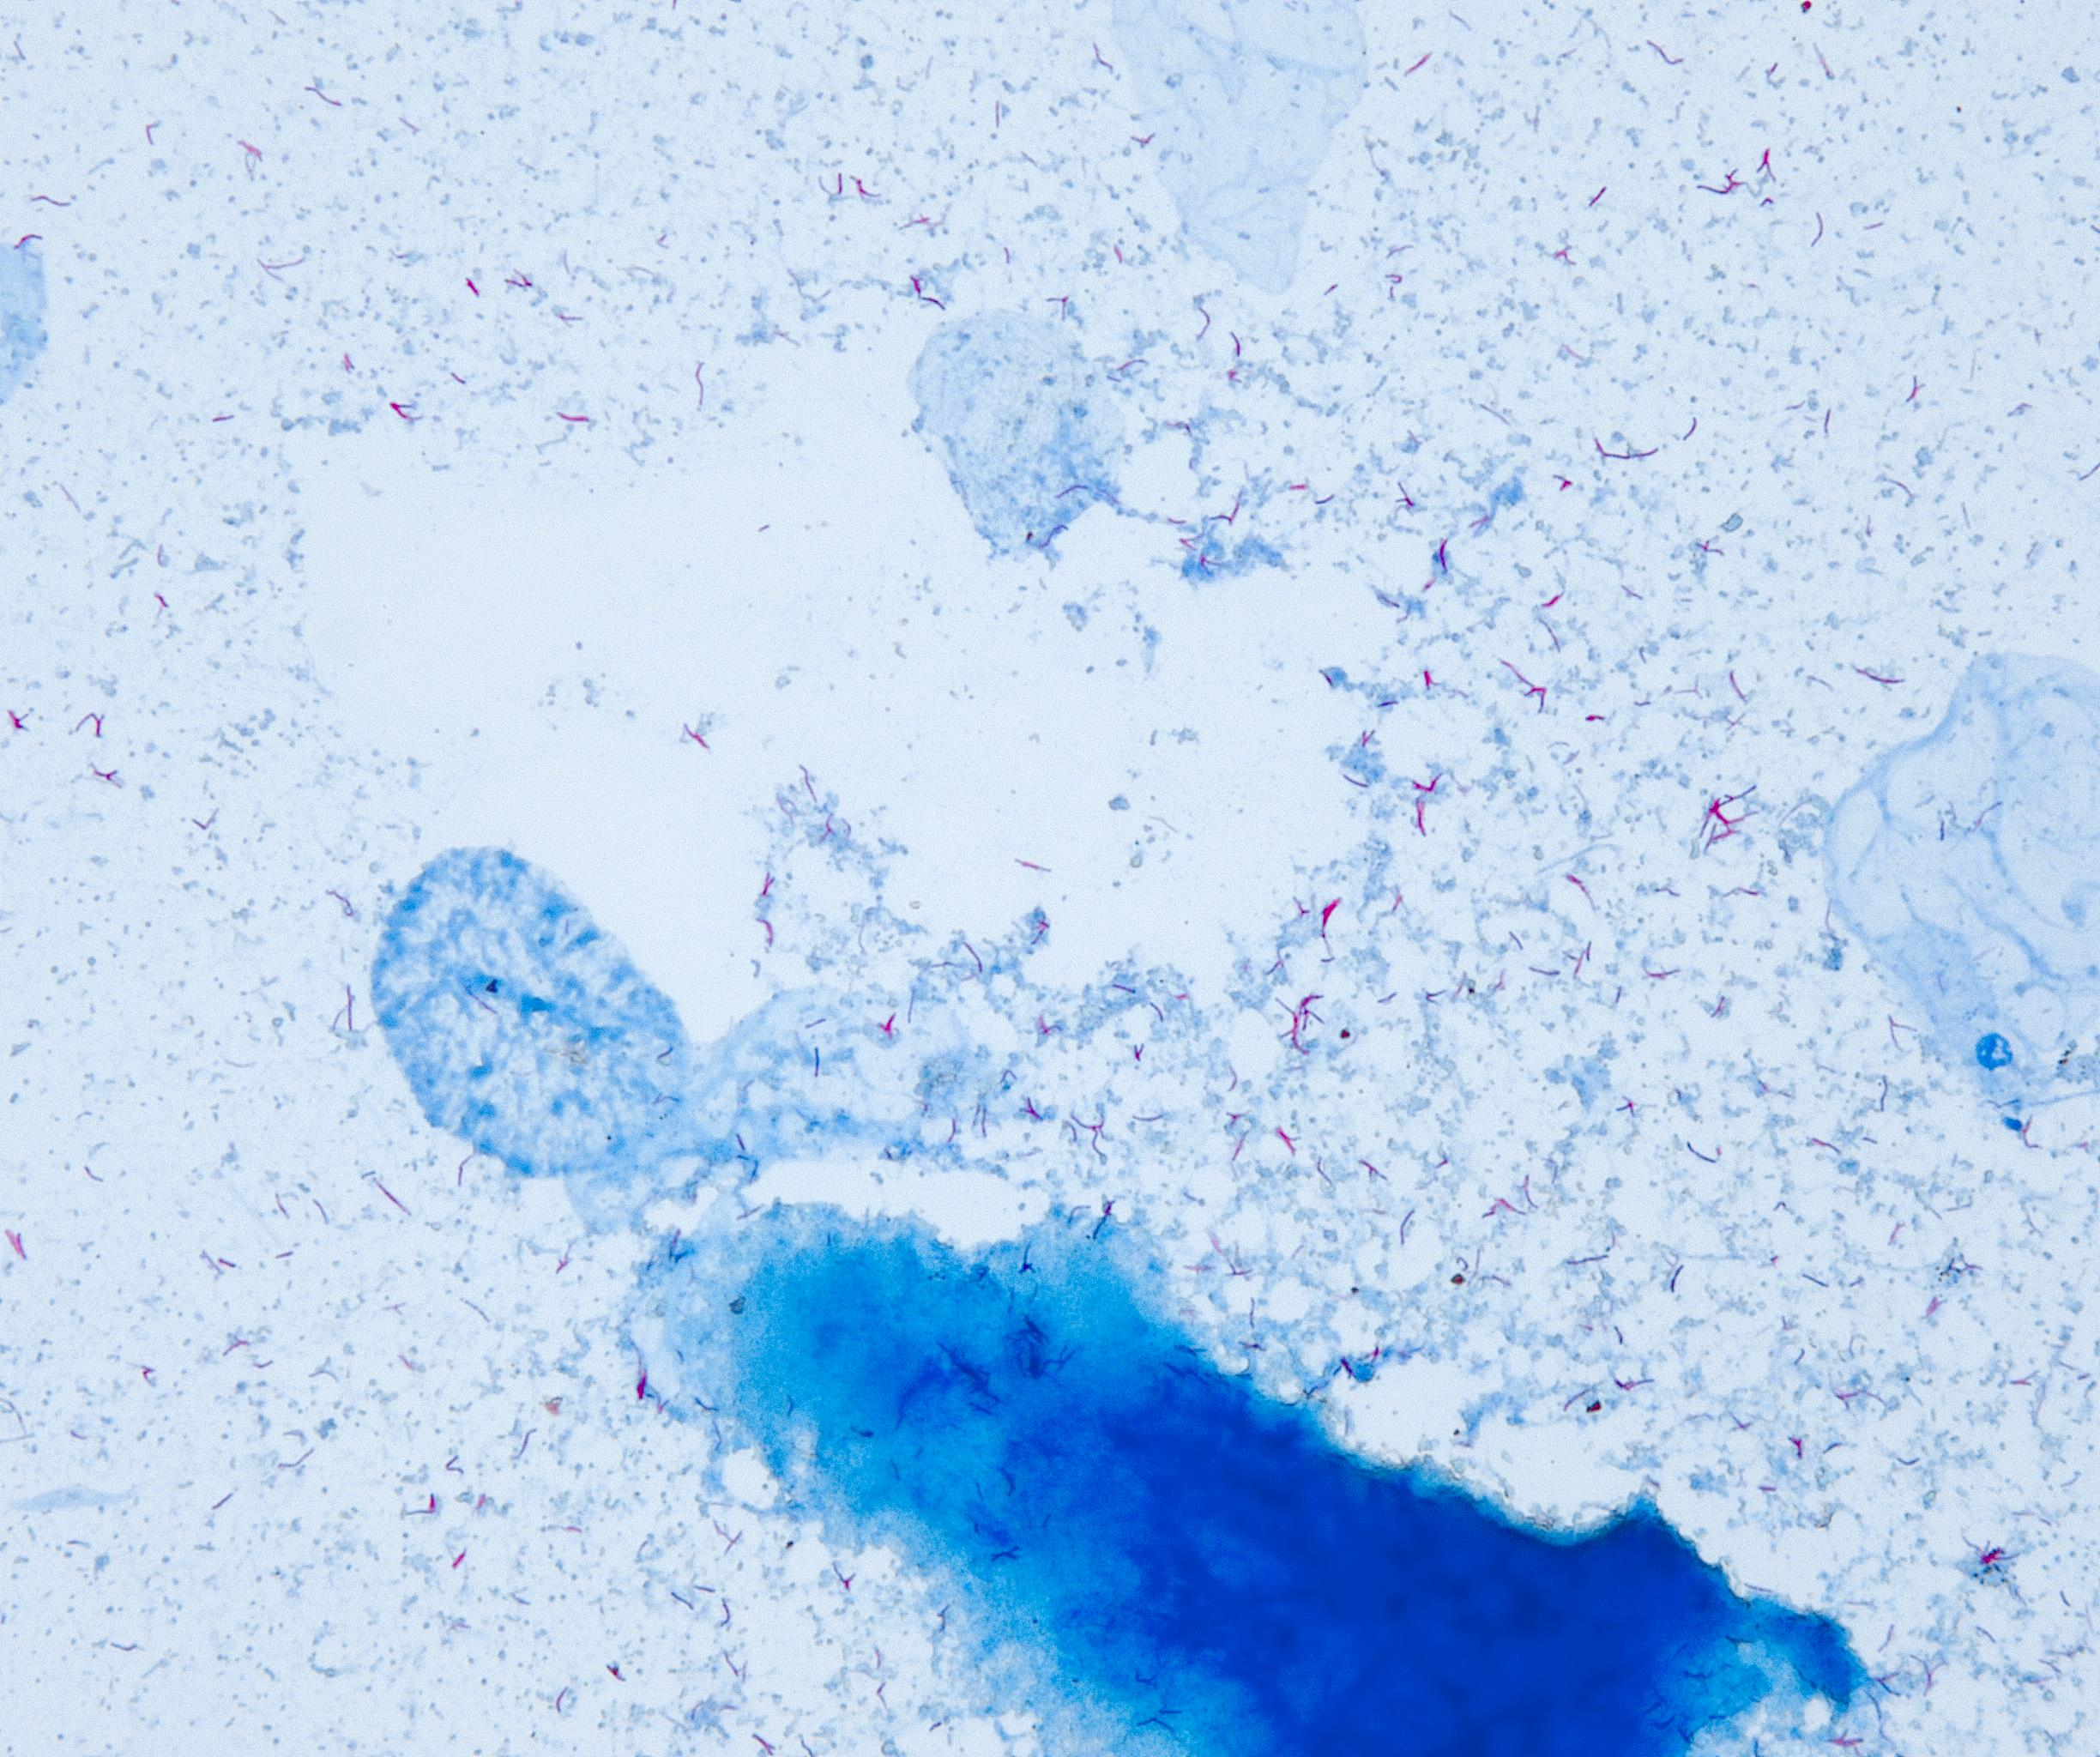

In [4]:
def get_image(idx, df, numpy=False, to_float=False):
    """Helper function to fetch image from disk"""
    path = df.loc[idx, "file_path"]
    assert os.path.exists(path)
    img = Image.open(path)
    if numpy:
        arr = np.asarray(img)
        if to_float:
            arr = arr / 255.0
        return arr
    else:
        return img

img = get_image(5, train_df)
img

Compute Means and Standard Deviations for Normalization:

In [5]:
means = []
stds = []

for idx in range(1000):
    arr = get_image(idx, train_df, numpy=True, to_float=True)
    means.append(arr.mean(axis=(0, 1)))
    stds.append(arr.std(axis=(0, 1)))

MEANS = np.vstack(means).mean(axis=0)
STDS = np.vstack(stds).mean(axis=0)

print(MEANS, STDS)

[0.76158505 0.84897016 0.93600385] [0.11125104 0.07816156 0.0457446 ]


Create a custom Dataset: 

In [6]:
class tbDataset(Dataset):
    def __init__(self, df, transform=None, train=True):
        self.df = df
        self.transform = transform
        self.train = train
        if self.train:
            self.train = self.df.sample(frac=1.0, ignore_index=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = get_image(idx, self.df, numpy=False, to_float=False)
        label = int(self.df.loc[idx, "tb_positive"])
        if self.transform:
            img = self.transform(img)
        return img, label

Create DataLoaders in Lightning DataModule Class:

In [7]:
class tbDataModule(pl.LightningDataModule):
    def __init__(self, df, batch_size=64, num_workers=8):
        super().__init__()
        self.full_df = df
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),  # adds flipping
                transforms.Resize((224, 224), antialias=True),  # input size for ResNet
                transforms.ToTensor(),
                transforms.Normalize(MEANS, STDS),
            ]
        )

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_df, self.val_df = random_split(self.full_df, 1000)
            class_counts = self.train_df['tb_positive'].value_counts().sort_index()
            class_weights = 1. / class_counts
            sample_weights = self.train_df['tb_positive'].map(class_weights).values
            self.train_sampler = WeightedRandomSampler(weights=torch.tensor(sample_weights, dtype=torch.float),
                                                       num_samples=len(sample_weights),
                                                       replacement=True)
        elif stage == "test":
            self.val_df = self.full_df  

    def train_dataloader(self):
        return DataLoader(
            tbDataset(self.train_df, transform=self.transform),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            sampler=self.train_sampler
        )

    def val_dataloader(self):
        return DataLoader(
            tbDataset(self.val_df, transform=self.transform),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False
        )

    def test_dataloader(self):
        return DataLoader(
            tbDataset(self.val_df, transform=self.transform),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False
        )

Define LightningModule for Model Training:

In [8]:
class tbModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, num_classes=2):
        super().__init__()
        self.lr = learning_rate
        self.num_classes = num_classes
        
        self.net = resnet18(weights=None)

        pretrained_weights = torch.load(weights_path) 
        model_dict = self.net.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_weights.items() if k in model_dict and "fc" not in k}
        model_dict.update(pretrained_dict)
        self.net.load_state_dict(model_dict)

        self.net.fc = nn.Linear(self.net.fc.in_features, self.num_classes)
        nn.init.xavier_uniform_(self.net.fc.weight)  
        nn.init.zeros_(self.net.fc.bias)

        self.test_accuracy = Accuracy(task="binary", num_classes=self.num_classes)

    def forward(self, X):
        return self.net.forward(X)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        imgs, labels = imgs.to(self.device), labels.to(self.device)
        logits = self.net.forward(imgs)
        loss = nn.functional.cross_entropy(logits, labels)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        imgs, labels = imgs.to(self.device), labels.to(self.device)
        logits = self.net.forward(imgs)
        loss = nn.functional.cross_entropy(logits, labels)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        imgs, labels = imgs.to(self.device), labels.to(self.device)
        logits = self.net.forward(imgs)
        loss = nn.functional.cross_entropy(logits, labels) 
        preds = torch.argmax(logits, dim=-1)
        self.test_accuracy.update(preds, labels)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

Train the Model:

In [9]:
# Main training script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = tbDataModule(tb_labels_df)

model = tbModel()
model = model.to(device)

logger = pl.loggers.CSVLogger(save_dir=LOGGER_DIR, name="tb_demo9")

# Using early stopping callback
early_stop_callback = EarlyStopping(
    monitor='val_loss',  # loss calculated on the validation set
    patience=10,  # early stop if loss doesn't improve after 10 epochs
    verbose=True,
    mode='min'
)

trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=50, 
    logger=logger,
    callbacks=[early_stop_callback]  # early stopping
)

trainer.fit(model, data)
trainer.test(model, data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/ngsci/project/logs/tb_demo9

  | Name          | Type           | Params
-------------------------------------------------
0 | net           | ResNet         | 11.2 M
1 | test_accuracy | BinaryAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.154


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.132


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.128


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.124


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.117


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.102


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.102. Signaling Trainer to stop.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9848709106445312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9848709106445312}]